
 **Main Title**
## Exploring the relationship between Wellness, Training load and Performance in the Canadian Women's Rugby 7s Team
### Sanghamesh S Vastrad [1005912096]
### Lixiang Wei[1001117374]
#### Dec 10, 2019


## Introduction
### Background
The Canadian National Women’s Rugby Team is interested in the relationship between training load, performance and wellness in Rugby 7s. Rugby 7s is a fast-paced, physically demanding sport that pushes the limits of athlete speed, endurance and toughness. Rugby 7s players may play in up to three games in a day, resulting in a tremendous amount of athletic exertion. Substantial exertion results in fatigue, which may lead to physiological deficits (e.g., dehydration), reduced athletic performance, and greater risk of injury.

Despite the importance of managing training load in professional athletics, very little is known about its effects, and many training decisions are based on “gut feel.” Currently, training load is measured through a combination of subjective measurements (asking players how hard they worked) and objective measurements from wearable technology. Wellness is typically estimated by asking players how they feel in wellness surveys. However, there is no agreed-upon standard of defining wellness so the relationship between training load, performance and wellness is unclear.

### Purpose of this project
1. Define appropriate measurement for wellness, performance, training load based on subjective survey, RPE, and GPS data sets
2. Predict player's performance based on wellness and training load measurement
3. Come up with statistical inference to help team prepare for the game better


## Data Exploration

### Wellness Data
(<b>Notebook</b>:[WellnessMeasure.ipynb](https://nbviewer.jupyter.org/github/weilixiang/sta2453_project1/blob/master/WellnessMeasure.ipynb))<br>

The original wellness data of athletes consists of 19 columns, of which there were 11 quantitative measures and 6 qualitative measures with the other two columns being Date and PlayerID. Our aim for this dataset is to come up with a quantitative  summary measure(s). For understanding what each variable means, please refer to the [CodeBook](https://www.dropbox.com/s/c5v4hig2afq881h/3.%20DataFest%202019%20-%20Codebook.xlsx?dl=0). 

<b>Note:</b> We decided to take two routes. One was that of factor analysis which can be found at the notebook over here: [Wellness-FactorAnlaysis.ipynb](https://nbviewer.jupyter.org/github/weilixiang/sta2453_project1/blob/master/Wellness%20-%20Factor%20Analysis.ipynb) and the other which we are going to describe in this report. The one we describe over here turns out to be better in terms of summary measures being less correlated. The approach followed was to try to come up with one quantitative value and keep the categorical variables intact.

For complete understanding as to how we cleaned the data, please refer to this notebook: [WellnessMeasure.ipynb](https://nbviewer.jupyter.org/github/weilixiang/sta2453_project1/blob/master/WellnessMeasure.ipynb). In this notebook, we add all the quantitative values after scaling them from 1-7 and come up with a <b>WellnessScore</b>. But we soon realize that the data we had wasn't completely independent. Intuitively, doesn't our wellness today depend on how we felt yesterday or even a week before? So, we define a new score by applying exponential moving average to the WellnessScore. Now, each player's <b>'EWMScore'</b> will depend on a week of WellnessScores with exponentially decreasing weights as me move further back in time. The dataset looks like this:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)
dfWell = pd.read_csv('https://raw.githubusercontent.com/weilixiang/sta2453_project1/master/Clean%20Data/WellnessMeasure.csv')
dfWell.head()

,Date,PlayerID,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,WellnessScore,EWMScore
0,2017-08-01,14,No,No,No,Okay,Yes,34.000000,34.000000
1,2017-08-01,2,No,No,No,Excellent,Yes,35.824138,35.824138
2,2017-08-01,3,No,No,No,Excellent,Yes,30.000000,30.000000
3,2017-08-01,5,No,No,No,Excellent,Yes,31.596552,31.596552
4,2017-08-01,13,No,No,No,Okay,Yes,29.862069,29.862069


Let us visualize the scores so that we can see what this actually means. The comparison of WellnessScore and EWMScore for Player with ID 1 is as follows:

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


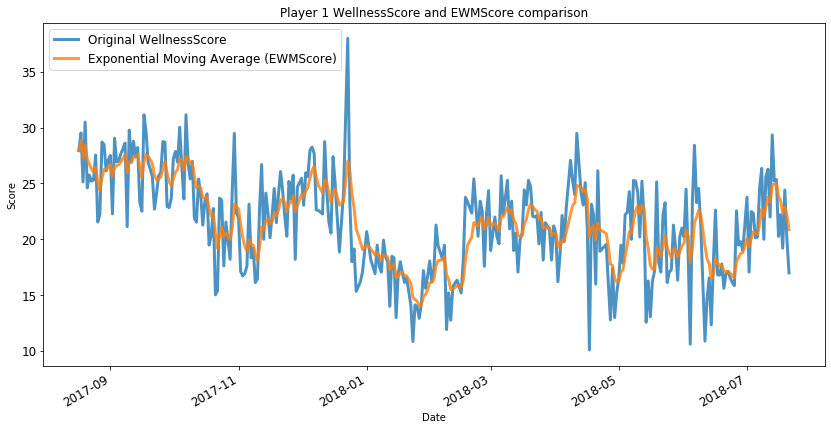

In [3]:
# Let us visualize the wellness and EWM scores of Player 1
Player1 = dfWell[dfWell.PlayerID == 1]
plt.figure(figsize=(14, 7))
# Convert the Date column to a pandas datetime object so that the axis labels get rendered properly
Player1.index = pd.to_datetime(Player1['Date'])
plt.plot(Player1.WellnessScore, lw=3, alpha=0.8, label='Original WellnessScore')
plt.plot(Player1.EWMScore, lw=3, alpha=0.8, label='Exponential Moving Average (EWMScore)')
plt.title('Player 1 WellnessScore and EWMScore comparison')
plt.xlabel('Date')
plt.ylabel('Score')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.gcf().autofmt_xdate()
plt.show()

### Training Load Data(RPE Dataset)

(<b>Notebook</b>:[RPE_cleaning.ipynb](https://github.com/weilixiang/sta2453_project1/blob/master/RPE_cleaning.ipynb))<br>

The original wellness data of athletes consists of 14 columns, of which there were 7 quantitative measures and 5 qualitative measures with the other two columns being Date and PlayerID. Our aim for this dataset is to come up with a quantitative  summary measure(s) to. For understanding what each variable means, please refer to the [CodeBook](https://www.dropbox.com/s/c5v4hig2afq881h/3.%20DataFest%202019%20-%20Codebook.xlsx?dl=0). 

<b>Note:</b> We decided to take two routes. One was that of factor analysis (which can be found at the notebook over here: [RPE_cleaning.ipynb](https://github.com/weilixiang/sta2453_project1/blob/master/RPE_cleaning.ipynb)) and the other which we are going to describe in this report. 
However, factor analysis does not work well. When we plot the new factors compared to AccelerationImpulse, we do not see any clear pattern. Hence, we decide to either come up with a new performance measure instead of AccelerationImpulse.

Firstly, we captured all the missing values from the same date, and cleaned the data. We dropped the columns ObjectiveRating, BestoutofSelf, and FocusRating, since there are too many missing values here. Besides, we removed all the rows still with missing values. Up to here, dimension of our RPE data set is (7621, 11). Secondly, we have players who did same training session multiple times. We would like to average their performance for the same session types. Finally, the dimension was reduced to (7192, 11). 

After we came up with new performance measure, I investigated the relationship between some variables and new performance measure. Here is an example: I would like to see whether load status will affect player's performance. I conducted Tukey test, which is a pairwise group mean comparison. 

In [13]:
#pairwise_tukeyhsd(df["PerformanceScore"],df["Load_Status"]).summary()

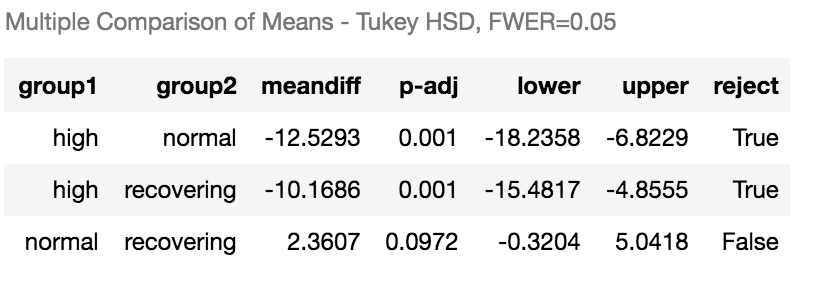

In [14]:
from IPython.display import Image
Image(filename='tukey.png')

As we can see, the test for normal group and recovering group suggests there is no difference between group mean. However, we can see that high group has significant mean difference compared to normal group and recovering group. Also, the mean difference is negative, which means if a player has higher training load, it has higher performance score than other two groups.

### Performance Measure (GPS Dataset)
(<b>Notebook</b>:[PerformanceMeasure.ipynb](https://nbviewer.jupyter.org/github/weilixiang/sta2453_project1/blob/master/PerformanceMeasure.ipynb))<br>

The aim for this dataset is to find a single performance measure per game for each player. We first thought of having a measure of a highest acceleration value per player, but it didn't show much variation and all the players performance seemed to be very similar. 

We then came up with the idea of having a <b>PerformanceScore</b>, which was a score on the scale of 0-100 and would be calculated in the following manner:<br>
<ol>
    <li>Find out the frame of highest speed within each game for each player</li>
    <li>Find the corresponding maximum values of accelLoad and accelImpulse if there are multiple frames with highest speed</li>
    <li>Give Speed, AccelLoad and AccelImpulse equal weights and scale the score to 100.</li>
</ol>

We were also curious to see if the outcome of the game or the points difference had any impact on the players. We wanted to know if players perform better when their team is under pressure with a large points difference and if players performance better or worse when the team is winning or losing. So we added those measures into the dataset using the games data as well. Our final dataset looked like this:

In [15]:
performance = pd.read_csv('https://raw.githubusercontent.com/weilixiang/sta2453_project1/master/Clean%20Data/' +
                          'PerformanceMeasure.csv')
performance.head()

,GameID,Date,PlayerID,AccelImpulse,AccelLoad,Speed,PerformanceScore,Outcome,PointsDiff
0,1,2017-11-30,2,0.524367,0.264378,0.754193,51.431257,W,19
1,2,2017-11-30,2,0.524367,0.264378,0.754193,51.431257,W,31
2,3,2017-11-30,2,0.524367,0.264378,0.754193,51.431257,W,17
3,1,2017-11-30,3,0.452520,0.333518,0.753256,51.309794,W,19
4,2,2017-11-30,3,0.452520,0.333518,0.753256,51.309794,W,31


The PerformanceScore we came up with looks decent with values ranging from 17 all the way up to 80. The distribution of PerformanceScore is as follows:

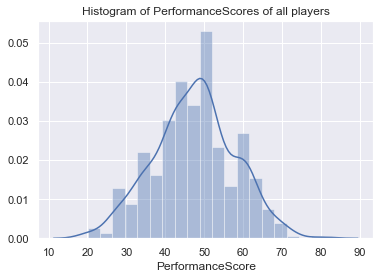

In [16]:
sns.set()
sns.distplot(performance.PerformanceScore)
plt.title('Histogram of PerformanceScores of all players')
plt.show()

We can also see from the Player wise PerformanceScore below that there is far more variability in our performance measure now. Also, note that we have removed players 18-21 as they didn't play any game. 

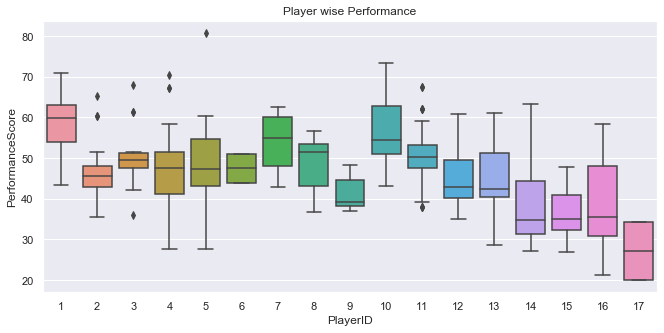

In [17]:
fig, ax = plt.subplots(figsize=(11,5))
sns.boxplot(x="PlayerID", y="PerformanceScore", data=performance)
plt.title('Player wise Performance')
plt.show()

## Model Selection and Fitting

In [18]:
import pandas as pd
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [19]:
#df = pd.read_csv('~/Desktop/merged_data.csv')
df = pd.read_csv("https://raw.githubusercontent.com/weilixiang/sta2453_project1/master/merged_data.csv")

### Model Selection

   The typical regression model assumes all rows should be independent. However, in our data set, we have multiple observations(rows) for each player. These rows are dependent. We should not use typical linear regression.
   
   Linear mixed models are an extension of simple linear models to allow both fixed and random effects, and are particularly used when there is non independence in the data, such as arises from a hierarchical structure.
   
   When there are multiple levels, such as performances on different date from same player, the variability in the outcome can be thought of as being either within group or between group. Performance level observations are not independent, as within a given player performance are more similar.
   
   The advantages of using mixed:
   1. Keep as many rows of data as possible, instead of aggregating data by player. Although aggregate data analysis yields consistent and effect estimates and standard errors, it does not really take advantage of all the data, because player data are simply averaged.
   
   2. Even if we can run regression for each player, each model does not take advantage of the information in data from other players. This can cause some bias since we consider only for one specific player.
   
   3. It keeps the flexibility in treating time as continuous.
   
#### Linear Mixed Effects Model (LME)

A typical regression model: 

 Y  = X$\beta$ + $\epsilon$,  where X is fixed effects, $\epsilon$ is random noise

Linear Mixed Effects Model:

Y = X$\beta$ + Z$\mu$ + $\epsilon$ 

Where y is a Nx1 column vector of the outcome variables,
X is a Nxp matrix of the p predictor variables,
$\beta$ is a px1 column vector of the fixed-effects regression coefficients,
Z is a Nxq design matrix for random effects, 
u is a qx1 random complement to fixed $\beta$,
$\epsilon$  is a Nx1 column vector of the residuals

#### Model Assumptions

1. Performance variance should be homogeneous for all players
2. Linearity(Residuals should be random)
3. Normality(Residuals should form a normal distribution

### Model Fitting

Our goal is to predict a player's overall performance based on variables from wellness, rpe, gps data as described above. We would like to build a multiple linear mixed effects model on variables that are significantly impacting player's performance. In order to achieve this, we applied Backward Elimination. We will firstly build a full model based on all variables we have. Consider the feature with the highest P-Value. If its P-value is greater than significance level (We fix 0.1 as significance level), we will eliminate this variable and build a new model. Until every variable has p-value < 0.1, our model is ready.

The reason for choosing Backward Elimination:
1. Although backward elimination and forward elimination will give the same result, by using backward elimination, we can manually reduce our model step by step, instead of running a built-in function and only getting the final model
2. By reducing on variable at a time, we can also compare some other criteria to determine if the reduced model is as good as the previous model. For example, we can compare AIC, BIC, Likelihood, and Anova table.

In linear mixed effects model, in order to measure how good the model is, a useful technique is called REML – residual maximum likelihood. We will use this criteria to determine whether the reduced model is as good as full model.

Let's take a look at our full model

In [20]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

full_md = smf.mixedlm("PerformanceScore  ~ SessionType +  Duration + RPE + SessionLoad + \
    DailyLoad + AcuteLoad + ChronicLoad + AcuteChronicRatio + Load_Status + \
        Outcome + PointsDiff + Pain + Illness + Menstruation + \
       Nutrition + NutritionAdjustment + EWMScore", df,groups = df["PlayerID"])
                 
mdf = full_md.fit()
print(mdf.summary())

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      PerformanceScore
No. Observations:      562          Method:                  REML            
No. Groups:            17           Scale:                   58.6021         
Min. group size:       3            Likelihood:              -1956.4791      
Max. group size:       80           Converged:               Yes             
Mean group size:       33.1                                                  
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                         50.766    8.679  5.849 0.000  33.755 67.777
SessionType[T.Game]               -0.501    2.385 -0.210 0.834  -5.175  4.173
SessionType[T.Mobility/Recovery]   0.331    2.774  0.119 0.905  -5.106  5.769
Sessio

As we can see, ChronicLoad has p-value 0.992, which is significantly larger than 0.1, we will drop it for next model. Keep in mind, the REML is about 58.6.

Since the process is repetitive, please refer to the [Model_Selection](https://github.com/weilixiang/sta2453_project1/blob/master/Model_Selection.ipynb). We will drop SessionType, Menstruation, RPE, SessionLoad, and Duration step by step.
Again, even if we have insignificant p-value for some levels in a categorical variable, we still need to keep it if there exist at least some significant levels.

In [21]:
md6 = smf.mixedlm("PerformanceScore  ~ DailyLoad + AcuteLoad + \
AcuteChronicRatio + Load_Status +  Outcome + PointsDiff + Pain + Illness +\
       Nutrition + NutritionAdjustment + EWMScore", df,groups = df["PlayerID"])
                 
mdf = md6.fit()
print(mdf.summary())

                 Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    PerformanceScore
No. Observations:    562        Method:                REML            
No. Groups:          17         Scale:                 58.7169         
Min. group size:     3          Likelihood:            -1958.8323      
Max. group size:     80         Converged:             Yes             
Mean group size:     33.1                                              
-----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------
Intercept                   54.331    8.054  6.746 0.000  38.546 70.116
Load_Status[T.normal]       -6.640    2.440 -2.722 0.006 -11.422 -1.859
Load_Status[T.recovering]   -4.826    2.965 -1.628 0.104 -10.636  0.984
Outcome[T.W]                -2.610    1.309 -1.994 0.046  -5.176 -0.044
Pain[T.Ye

Up until this model, our REML climbs up to 58.8, and all variables or at least one level of categorical variable have p-value <0.1, we confirm this is our final model.

Some Interpretations: 
1. The coefficients for two levels of Load_Status are about -8. The baseline level is high, so we can conclude if a player did a high load training before the game, their performance score is about 8 higher than normal training or recovering.

2. The coefficients for two levels of Illness are about 5.6 and -9. The baseline level is No, so we can conclude if a player is ill, her performance score is lower by 9. It is noticeable that if the player feels sightly off, her performance score is actually 5.67 higher.

3. EWMScore has coefficient -0.412, which indicates a negative relationship between performance and EWM score. This makes sense, since a high EWMScore means less soreness, fatigue. This indicates their training load is not high. Thus, it is consistent with first interpretation.

### Assumption Checking


We will plot the residuals versus fitted value to verify if residuals are random. Also, qq-plot will check the normality assumptions.

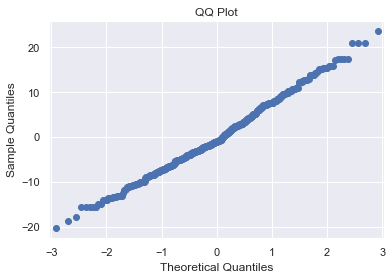

In [22]:
fig = sm.qqplot(mdf.resid)
plt.title("QQ Plot")
plt.show()

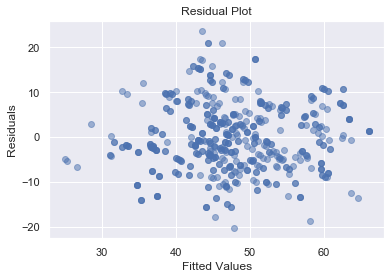

In [23]:
plt.scatter(df['PerformanceScore'] - mdf.resid, mdf.resid, alpha = 0.5)
plt.title("Residual Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

As we can see, the normality is good, as all data points are roughly on or closed to line. 
All residuals are pretty random, there is no apparent pattern or polynomial that can describe the residuals.

### Inference Checking
After we conclude some associations between performance and other variables in our model, we would like to include some visualizations to verify our results.
Here, we will plot Load Status, Illness, Pain, and Nutrition as x-axis, and performance score as response variable.
As shown in the box plots, the player with high training load has significant better performance than other two status. The players feel sightly off performance slightly better than other two groups. But here, we only have 1 observation for ill player, we may doubt if a player feels ill, probably she will be out of tomorrow's games.
If a player feels painful, she usually has better performance. This is reasonable, since pain is highly correlated with load status, if the status is high, most of player feels painful. For Nutrition, the difference is not significant, and the result is a bit surprised. Since a player has excellent nutrition has lower performance than those who is just okay.

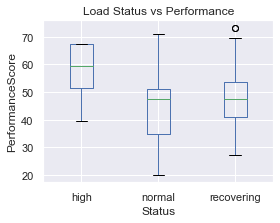

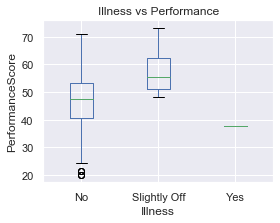

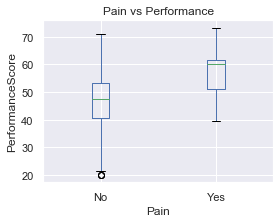

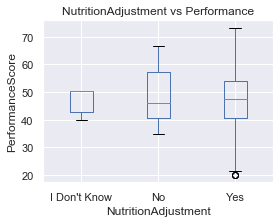

In [24]:

df.boxplot(column = 'PerformanceScore', by = "Load_Status",figsize=(4,3))
plt.title('Load Status vs Performance')
plt.suptitle("")
plt.xlabel('Status')  
plt.ylabel('PerformanceScore')

df.boxplot(column = 'PerformanceScore', by = "Illness",figsize=(4,3))
plt.title('Illness vs Performance')
plt.suptitle("")
plt.xlabel('Illness')  
plt.ylabel('PerformanceScore')

df.boxplot(column = 'PerformanceScore', by = "Pain",figsize=(4,3))
plt.title('Pain vs Performance')
plt.suptitle("")
plt.xlabel('Pain')  
plt.ylabel('PerformanceScore')

df.boxplot(column = 'PerformanceScore', by = "NutritionAdjustment",figsize=(4, 3))
plt.title('NutritionAdjustment vs Performance')
plt.suptitle("")
plt.xlabel('NutritionAdjustment')  
plt.ylabel('PerformanceScore')
plt.show()


## Conclusion
### How to improve player's performance?
1. I would suggest players to have more acute exercise, and less chronic exercise, so that the AcuteChronic Ratio is higher. In this way, they would have high training load status.

2. NutritionAdjustment is important for player's performance. A player being self-aware about Nutrition Adjustment seems to performance better than those who don't know about their nutrition levels. In our model, if the player has made nutrition adjustment for the training day, her performance is about 3 points higher on our performance scale.




### What are the problems in our model?
1. Should not include game result and points difference to predict future performance

2. A player may have multiple types of training sessions on the day before game. We should build regression models grouped by session types

3. Better/Complete data like heart rate would have allowed us to use models like the Bannister model and we could have come up with better summary measures.


## Reference

1. Avinash Navlani (2019), 
https://www.datacamp.com/community/tutorials/introduction-factor-analysis


2. Gabriela K Hajduk(2017), Introduction to linear mixed models
https://ourcodingclub.github.io/2017/03/15/mixed-models.html


3. Gelman, A. & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models. Cambridge University Press


4. Singer, J. D. & Willett, J. B. (2003). Applied Longitudinal Data Analysis: Modeling Change and Event Occurrence. Oxford University Press